<a href="https://colab.research.google.com/github/Archalharin/208469/blob/main/SARIMAX_Y_and_x_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [2]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.4 MB/s eta 0:00:00


In [1]:
!pip3 install numpy==1.26.4
!pip3 install pmdarima

In [6]:
# Dataframe & Linear Algebra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore")

# Data preprocessing
from sklearn.preprocessing import PowerTransformer

# Time serie
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Model Evaluation
from math import sqrt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Import dataset

In [7]:
data = pd.read_csv(r"/content/เขื่อนแม่กวงอุดมธารา1.csv")
data.set_index('ปี-เดือน', inplace=True)
data.columns = data.columns.str.strip()
data.index = pd.date_range(start = "2013-05", periods = len(data), freq = "M").to_period()
data.head()

,y,x1,x2,x3,x4
2013-05,47.34,29.29,65.29,1006.95,2.90
2013-06,45.02,28.86,71.14,1005.26,1.32
2013-07,45.88,27.89,77.24,1005.13,8.80
2013-08,51.90,27.30,80.79,1006.09,9.66
2013-09,77.58,27.46,78.93,1007.70,9.19


Data description

In [8]:
for i in data.columns:
    data[i] = data[i].astype("float")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 144 entries, 2013-05 to 2025-04
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       144 non-null    float64
 1   x1      144 non-null    float64
 2   x2      144 non-null    float64
 3   x3      144 non-null    float64
 4   x4      144 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


# Data visualization

In [10]:
round(data.describe(), 4)

,y,x1,x2,x3,x4
count,144.0000,144.0000,144.0000,144.0000,144.0000
mean,96.8513,27.1929,69.1835,1009.6231,3.2295
std,55.4457,2.3872,9.1906,3.4939,3.3447
min,23.9200,21.0500,44.6200,1004.3700,0.0000
25%,51.2825,25.7950,63.2000,1006.5275,0.4200
50%,84.6300,27.6550,71.4150,1009.0500,2.3750
75%,123.4925,28.7725,76.0875,1012.8700,4.7775
max,255.8800,32.5400,82.1700,1016.5100,15.1000


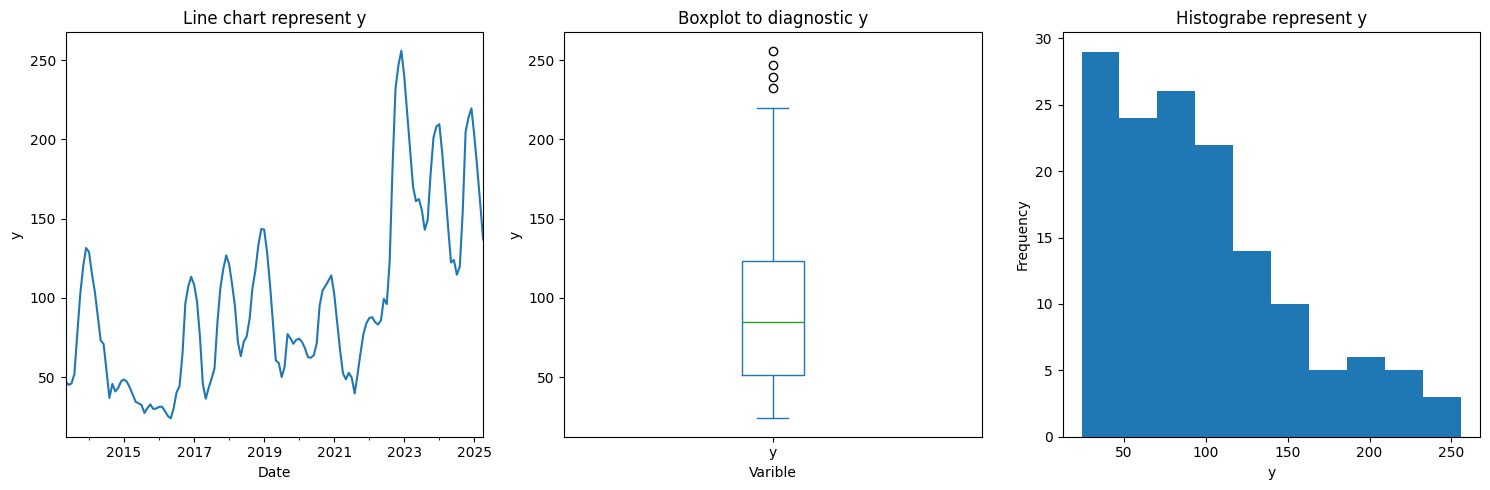

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
kind_list = ["line", "box", "hist"]
for i, kind in enumerate(kind_list):
    data["y"].plot(kind = kind, ax = ax[i])
ax[0].set(xlabel = "Date", ylabel = "y", title = "Line chart represent y")
ax[1].set(xlabel = "Varible", ylabel = "y", title = "Boxplot to diagnostic y")
ax[2].set(xlabel = "y", title = "Histograbe represent y")
plt.tight_layout()
plt.show()

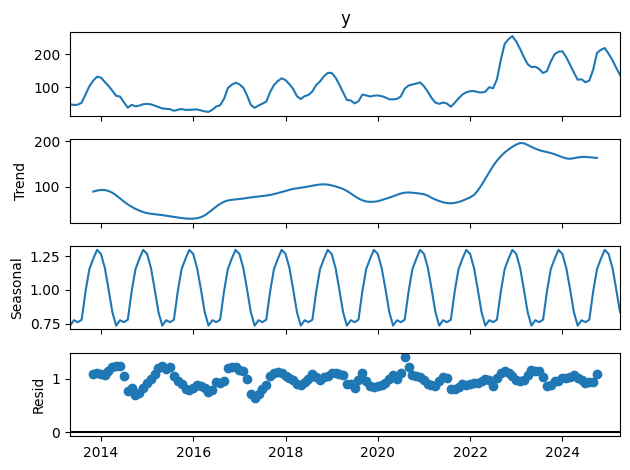

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose
sd = seasonal_decompose(data["y"].to_timestamp(), model = "multiplicative", period = 12)

# Plot
sd.plot()
plt.tight_layout()
plt.show()

Correlation matrix

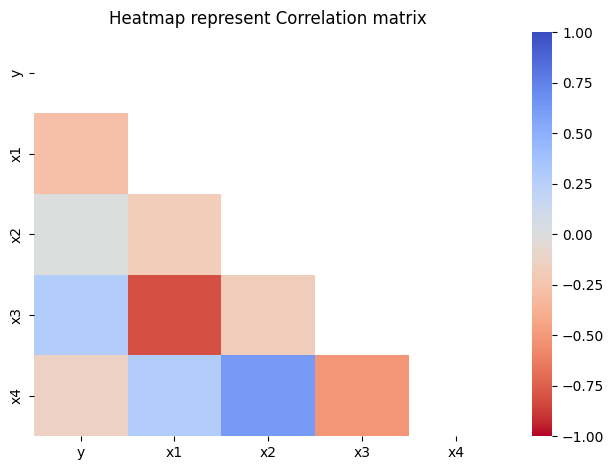

In [13]:
correlation = data.corr()
sns.heatmap(correlation, vmin = -1, vmax = 1, cmap = "coolwarm_r", mask = np.triu(correlation))
plt.title("Heatmap represent Correlation matrix")
plt.tight_layout()
plt.show()

# Split data

In [14]:
size = 12
x_train = data.drop(columns = "y")[:-size]
y_train = data["y"][:-size]
x_test = data.drop(columns = "y")[-size:]
y_test = data["y"][-size:]

# REGRESSION MODEL SARIMAX

In [15]:
from statsmodels.api import OLS, add_constant # OLS: Least square method
y = y_train
x = x_train
x = add_constant(x)
full_regr = OLS(y, x).fit()
print(full_regr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.097
Date:                Wed, 11 Feb 2026   Prob (F-statistic):             0.0180
Time:                        15:04:03   Log-Likelihood:                -704.26
No. Observations:                 132   AIC:                             1419.
Df Residuals:                     127   BIC:                             1433.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1191.6743   2768.970     -0.430      0.6



```
```

Check multicolinearity

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]

vif_data.sort_values(by = "VIF", ascending = False)[1:].reset_index(drop = True)

,feature,VIF
0,x3,4.282782
1,x1,4.181358
2,x2,2.352724
3,x4,2.325297


Stepwise regression

In [17]:
y = y_train
x = x_train["x4"]
# x = add_constant(x)
stepwise_regr = OLS(y, x).fit()
print(stepwise_regr.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.301
Model:                            OLS   Adj. R-squared (uncentered):              0.296
Method:                 Least Squares   F-statistic:                              56.38
Date:                Wed, 11 Feb 2026   Prob (F-statistic):                    8.21e-12
Time:                        15:04:07   Log-Likelihood:                         -778.00
No. Observations:                 132   AIC:                                      1558.
Df Residuals:                     131   BIC:                                      1561.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# SARIMAX Model

Find parameter p, d, q

In [48]:
power_y = PowerTransformer(method = "box-cox", standardize = False).fit(y_train.values.reshape(-1, 1))
print("Lambda: ", round(power_y.lambdas_[0], 4))
y_tf = power_y.transform(y_train.values.reshape(-1, 1))
y_t_tf = power_y.transform(y_test.values.reshape(-1, 1))

Lambda:  -0.0175


In [51]:
train_df = pd.DataFrame(y_train)
train_df["y_transform"] = y_tf

test_dff = pd.DataFrame(y_test)
test_dff["y_transform"] = y_t_tf
y_tf

array([[3.73004151],
       [3.68305216],
       [3.70075205],
       [3.81593251],
       [4.18976202],
       [4.4452815 ],
       [4.58989108],
       [4.6758878 ],
       [4.65782127],
       [4.55462932],
       [4.45915039],
       [4.31301549],
       [4.13423253],
       [4.10573509],
       [3.84756673],
       [3.49410463],
       [3.69584673],
       [3.5927277 ],
       [3.64356439],
       [3.73043632],
       [3.75054314],
       [3.72250764],
       [3.64529814],
       [3.54231631],
       [3.42801335],
       [3.40301322],
       [3.37180097],
       [3.21232741],
       [3.31350172],
       [3.3830901 ],
       [3.29659871],
       [3.30602734],
       [3.33678014],
       [3.34160713],
       [3.25360238],
       [3.14712428],
       [3.08813478],
       [3.31381184],
       [3.5800325 ],
       [3.66606385],
       [4.00954445],
       [4.39160839],
       [4.48747277],
       [4.53923679],
       [4.49765669],
       [4.40320481],
       [4.16358879],
       [3.691

In [45]:
y_train_tf = np.log(y_train)
y_test_tf = np.log(y_test)
y_train_tf

,y
2013-05,3.857356
2013-06,3.807107
2013-07,3.826029
2013-08,3.949319
2013-09,4.351310
...,...
2023-12,5.338019
2024-01,5.344819
2024-02,5.253163
2024-03,5.128122


In [20]:
y_t_tf

array([[4.60972983],
       [4.62108586],
       [4.54982213],
       [4.58919915],
       [4.81877535],
       [5.08100115],
       [5.12092347],
       [5.14470431],
       [5.06935018],
       [4.9719619 ],
       [4.85454562],
       [4.7130515 ]])

In [21]:
# Definition ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

In [22]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(train_df["y"]).keys()
df_adf['ADF seasonal differencing order 0'] = adf_test(train_df["y"]).values
df_adf['ADF seasonal differencing order 1'] = adf_test(train_df["y"].diff(periods = 7).dropna()).values
df_adf['ADF seasonal differencing order 2'] = adf_test(train_df["y"].diff(periods = 7).diff(periods = 7).dropna()).values
df_adf['ADF seasonal differencing order 3'] = adf_test(train_df["y"].diff(periods = 7).diff(periods = 7).diff(periods = 7).dropna()).values
round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF seasonal differencing order 0,ADF seasonal differencing order 1,ADF seasonal differencing order 2,ADF seasonal differencing order 3
Test Statistic,-2.1362,-3.0331,-3.3728,-3.2644
p-value,0.2302,0.0319,0.0119,0.0165
Critical Value (1%),-3.4865,-3.4907,-3.4949,-3.4996
Critical Value (5%),-2.8862,-2.8880,-2.8898,-2.8918
Critical Value (10%),-2.5799,-2.5809,-2.5818,-2.5829


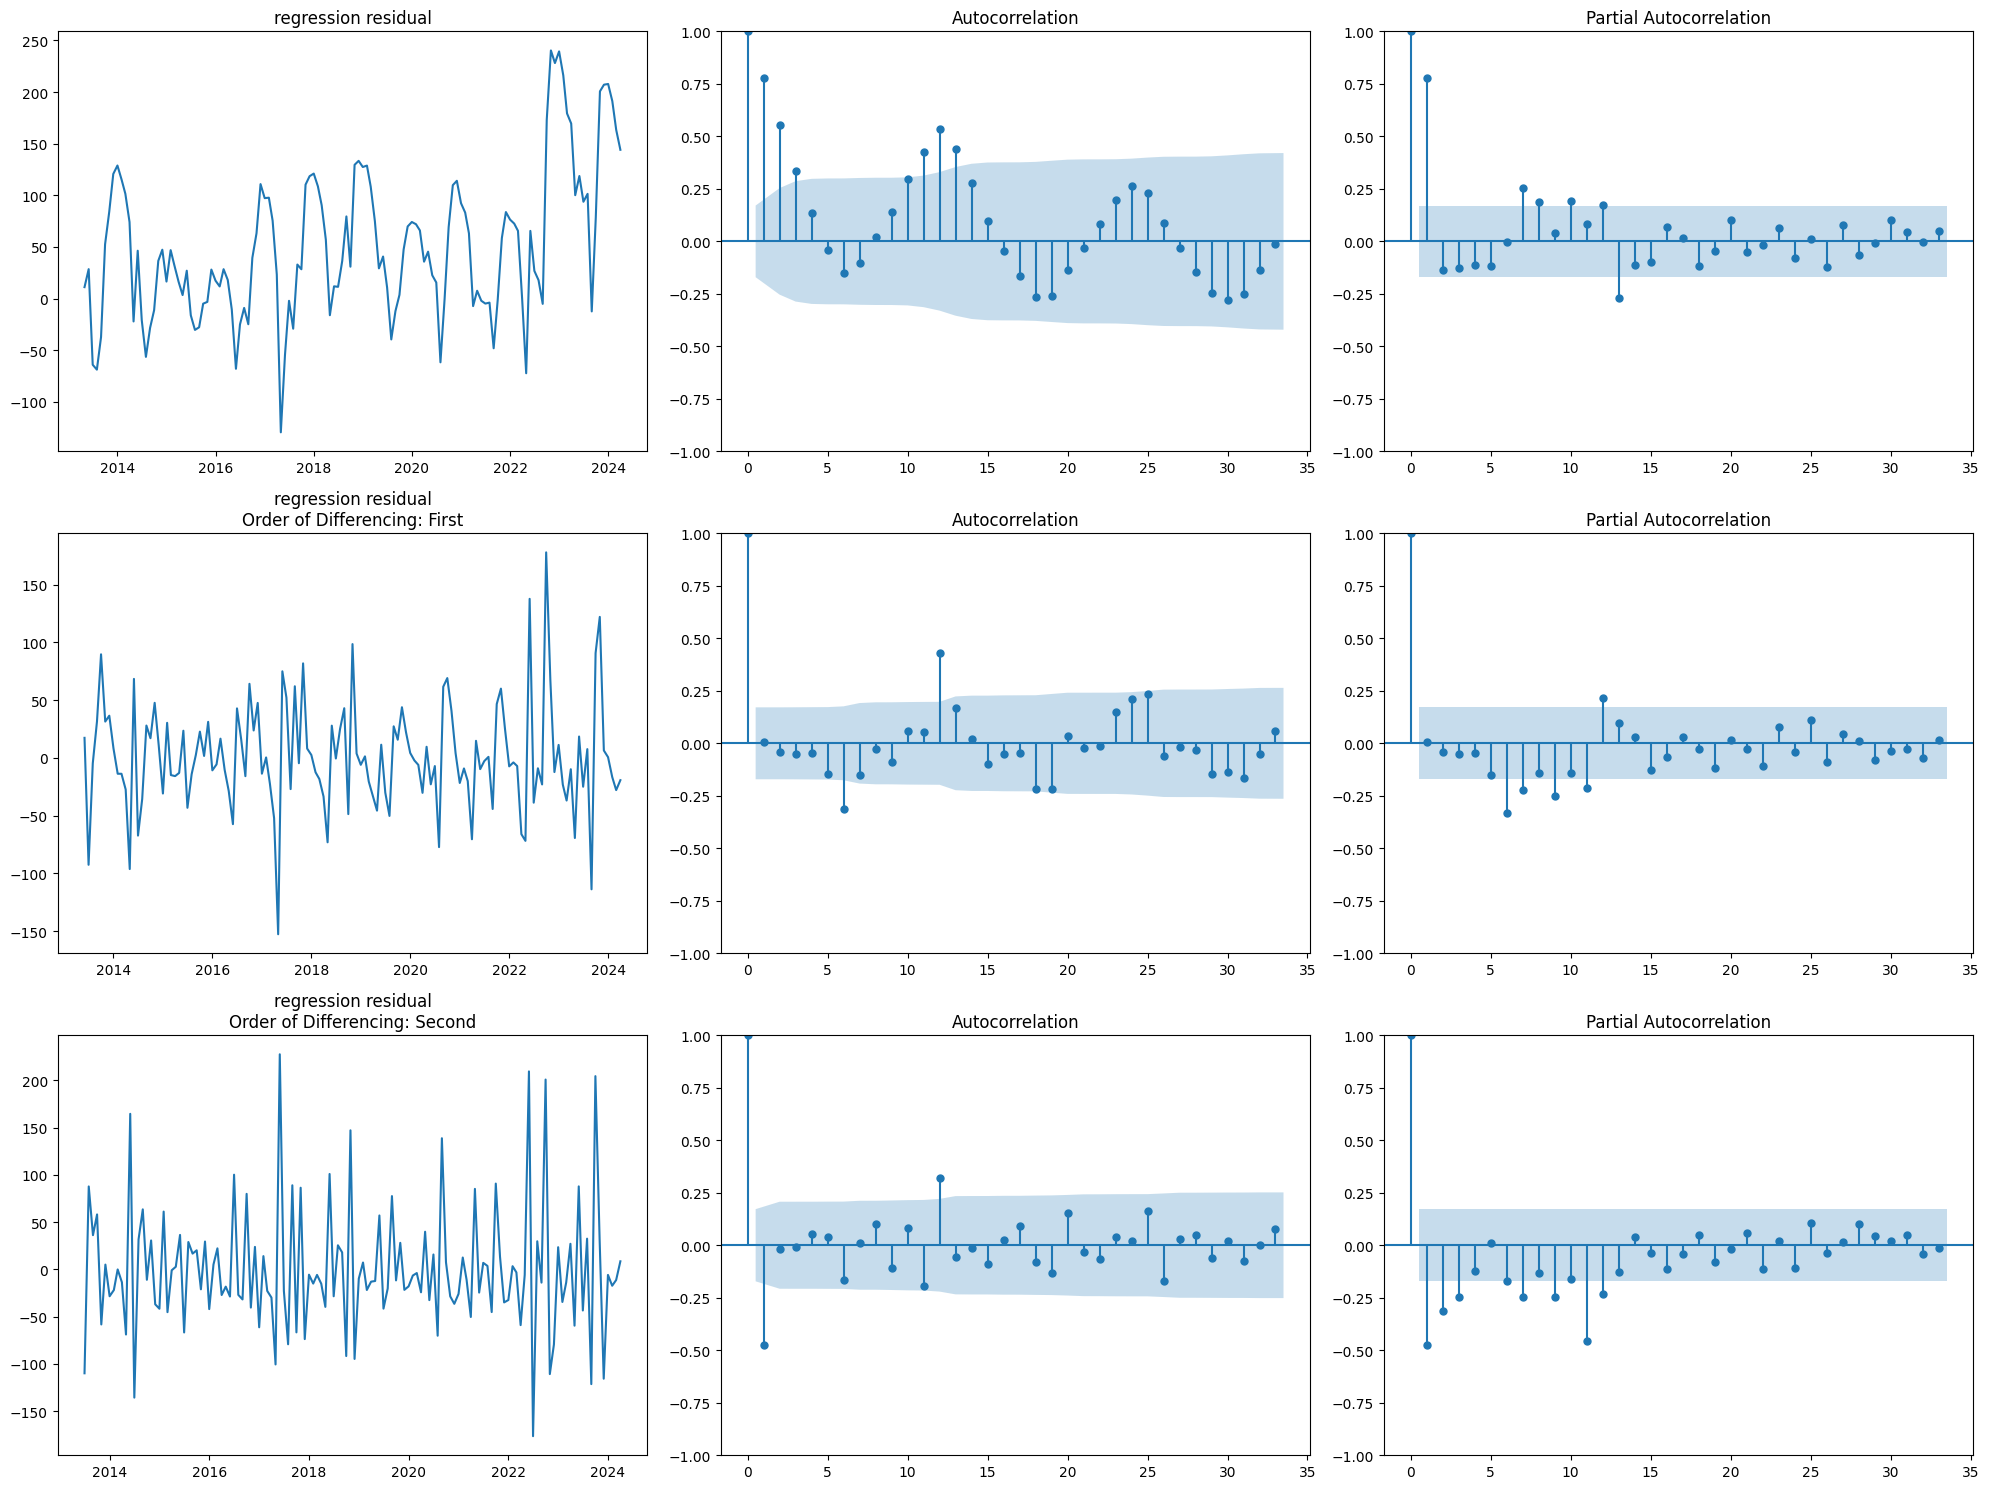

In [23]:
fig, axes = plt.subplots(3, 3, figsize = (20, 15), facecolor = 'w')
# regression residual
axes[0, 0].plot(stepwise_regr.resid.to_timestamp())
axes[0, 0].set_title('regression residual')
plot_acf(stepwise_regr.resid, ax = axes[0, 1], lags = round(len(stepwise_regr.resid)/4))
plot_pacf(stepwise_regr.resid, ax = axes[0, 2], lags = round(len(stepwise_regr.resid)/4))

# Order of Differencing: First
axes[1, 0].plot(stepwise_regr.resid.diff().dropna().to_timestamp())
axes[1, 0].set_title('regression residual\nOrder of Differencing: First')
plot_acf(stepwise_regr.resid.diff().dropna(), ax = axes[1, 1], lags = round(len(stepwise_regr.resid)/4))
plot_pacf(stepwise_regr.resid.diff().dropna(), ax = axes[1, 2], lags = round(len(stepwise_regr.resid)/4))

# Order of Differencing: Second
axes[2, 0].plot(stepwise_regr.resid.diff().diff().dropna().to_timestamp())
axes[2, 0].set_title('regression residual\nOrder of Differencing: Second')
plot_acf(stepwise_regr.resid.diff().diff().dropna(), ax = axes[2, 1], lags = round(len(stepwise_regr.resid)/4))
plot_pacf(stepwise_regr.resid.diff().diff().dropna(), ax = axes[2, 2], lags = round(len(stepwise_regr.resid)/4))

plt.tight_layout()
plt.show()

In [24]:
import itertools
max_p  = [0, 1, 2];  max_d = [0];  max_q = [0, 1]
max_SP = [0, 1]; max_SD = [1]; max_SQ = [0, 1]
periods = [12]
order_combinations = list(itertools.product(max_p, max_d, max_q, max_SP, max_SD, max_SQ, periods))
len(order_combinations)

24

In [52]:
list_sarimax_model = list()
for order in order_combinations:
    start_idx = order[1] + (order[4] * 12)
    model = SARIMAX(endog = y_tf, exog = x_train["x4"], order = order[:3], seasonal_order = order[3:]).fit()
    fitted = model.fittedvalues
    forecast = model.forecast(steps = len(y_test), exog = x_test["x4"])
    mape_train = MAPE(y_tf[start_idx:], fitted[start_idx:]) * 100; mse_train = MSE(y_tf[start_idx:], fitted[start_idx:]); mae_train = MAE(y_tf[start_idx:], fitted[start_idx:])
    mape_test = MAPE(y_t_tf, forecast) * 100; mse_test = MSE(y_t_tf, forecast); mae_test = MAE(y_t_tf, forecast)
    list_sarimax_model.append({"order": order[:3], "seasonal order": order[3:],
                             "MAPE train": mape_train, "RMSE train": sqrt(mse_train), "MAE train": mae_train,
                             "MAPE test": mape_test, "RMSE test": sqrt(mse_test), "MAE test": mae_test})
output_sarimax = round(pd.DataFrame(list_sarimax_model), 4)
output_sarimax = output_sarimax.sort_values(by = "MAPE test", ascending = True).reset_index(drop = True)
output_sarimax

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal order,MAPE train,RMSE train,MAE train,MAPE test,RMSE test,MAE test
0,"(1, 0, 0)","(1, 1, 1, 12)",2.3086,0.1298,0.0920,1.0677,0.0588,0.0509
1,"(1, 0, 0)","(0, 1, 1, 12)",2.3108,0.1299,0.0921,1.0747,0.0595,0.0512
2,"(1, 0, 1)","(0, 1, 1, 12)",1.9852,0.1144,0.0794,1.4427,0.0751,0.0699
3,"(1, 0, 1)","(1, 1, 1, 12)",1.9816,0.1143,0.0792,1.5212,0.0801,0.0740
4,"(2, 0, 0)","(0, 1, 0, 12)",2.3195,0.1331,0.0929,1.7873,0.1053,0.0866
5,"(2, 0, 1)","(0, 1, 0, 12)",2.4672,0.1403,0.0989,1.7903,0.1074,0.0866
6,"(0, 0, 1)","(1, 1, 0, 12)",5.6258,0.2849,0.2302,1.8317,0.1036,0.0865
7,"(2, 0, 1)","(0, 1, 1, 12)",2.2605,0.1259,0.0904,1.8795,0.1017,0.0896
8,"(2, 0, 0)","(1, 1, 0, 12)",2.1259,0.1198,0.0851,1.9417,0.0984,0.0929
9,"(1, 0, 1)","(0, 1, 0, 12)",2.4036,0.1389,0.0963,1.9938,0.1166,0.0972


SARIMAX 2,0,0,1,1,1,12

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                  91.502
Date:                              Wed, 11 Feb 2026   AIC                           -173.005
Time:                                      16:14:26   BIC                           -159.067
Sample:                                  05-31-2013   HQIC                          -167.344
                                       - 04-30-2024   Scale                            0.010
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x4            -0.0020      0.002     -0.880      0.379      -0.007       0.002
ar.L1          1.48

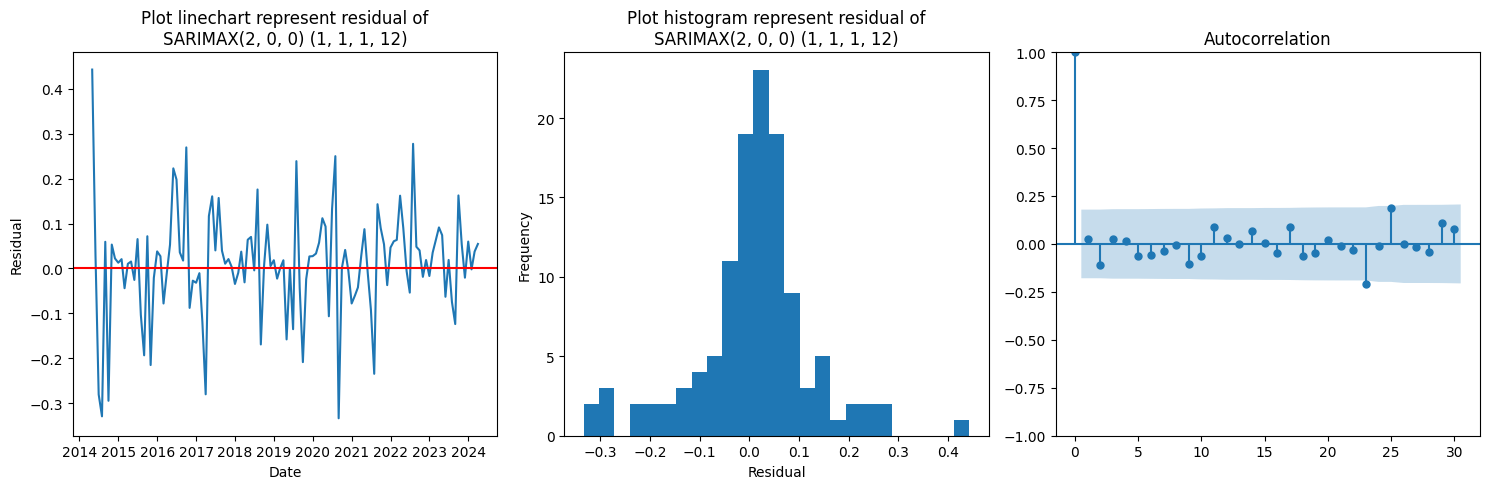

In [81]:
id = 16
sarimax_model = SARIMAX(endog = y_train_tf,exog = x_train["x4"], order = output_sarimax.iloc[id]['order'], seasonal_order = output_sarimax.iloc[id]['seasonal order'], concentrate_scale = True).fit()
print(sarimax_model.summary())

# diagnostic
resid_sarimax = sarimax_model.resid[12:]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
ax[0].plot(resid_sarimax.to_timestamp())
ax[0].axhline(y = 0, color = "r")
ax[0].set(xlabel = "Date", ylabel = "Residual", title = "Plot linechart represent residual of\nSARIMAX(2, 0, 0) (1, 1, 1, 12)")
ax[1].hist(resid_sarimax, bins = 25)
ax[1].set(xlabel = "Residual", ylabel = "Frequency",title = "Plot histogram represent residual of\nSARIMAX(2, 0, 0) (1, 1, 1, 12)")
plot_acf(resid_sarimax, lags = int(len(resid_sarimax) / 4), ax = ax[2])
plt.tight_layout()
plt.show()

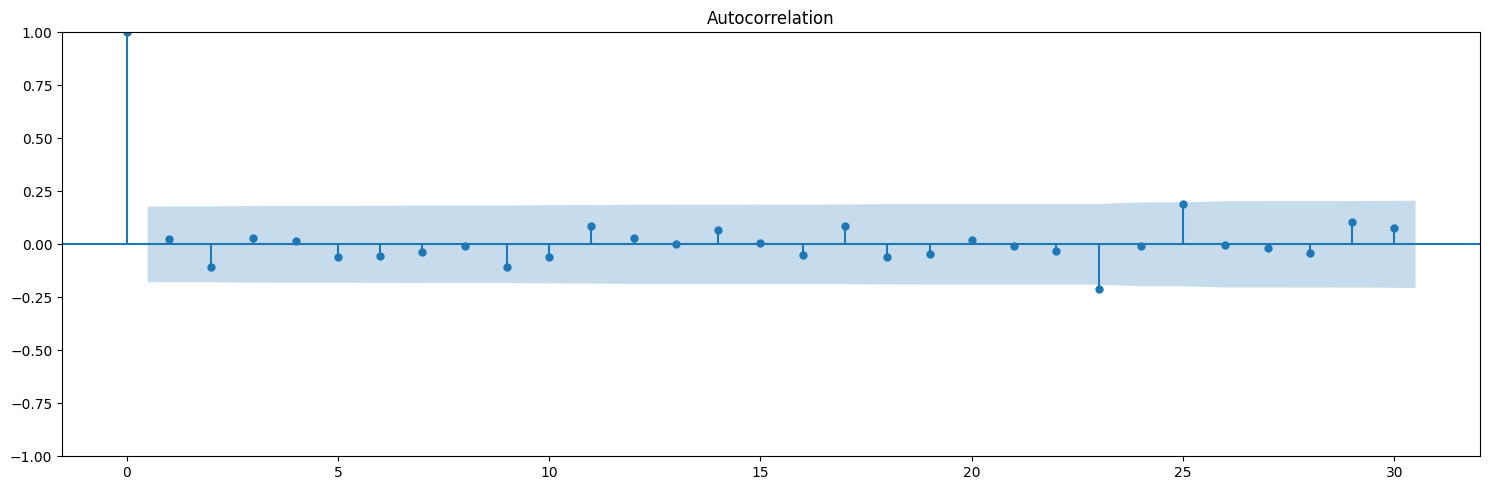

In [82]:
fig, ax = plt.subplots(figsize = (15, 5), facecolor = "w")
plot_acf(sarimax_model.resid[12:], lags = int(len(sarimax_model.resid[12:]) / 4), ax = ax)
plt.tight_layout()
plt.show()

In [83]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarimax_model.resid[12:])/4, 0)
bj = acorr_ljungbox(sarimax_model.resid[12:], lags = lag_idx, return_df = True)
bj.tail().T

,26,27,28,29,30
lb_stat,21.315267,21.353832,21.648961,23.505573,24.492336
lb_pvalue,0.725513,0.769443,0.797278,0.752915,0.749308


In [38]:
search_sarimax = auto_arima(y_tf,x_train[["x4"]],m = 12, information_criterion = "aic", stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-198.469, Time=2.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-121.962, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-190.562, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-179.368, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-123.611, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-179.391, Time=0.95 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-188.257, Time=1.11 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-195.527, Time=2.63 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-193.815, Time=2.50 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-166.641, Time=0.51 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-186.064, Time=2.47 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-194.952, Time=3.93 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-199.300, Time=2.87 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(2,1,1)(2,0,2)[12]

In [39]:
print(search_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 111.616
Date:                              Wed, 11 Feb 2026   AIC                           -209.233
Time:                                      15:18:30   BIC                           -189.106
Sample:                                  05-31-2013   HQIC                          -201.055
                                       - 04-30-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x4            -0.0011      0.002     -0.513      0.608      -0.005       0.003
ma.L1          0.58

Diagnostics model

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 111.882
Date:                              Wed, 11 Feb 2026   AIC                           -209.765
Time:                                      15:24:02   BIC                           -189.638
Sample:                                  05-31-2013   HQIC                          -201.587
                                       - 04-30-2024   Scale                            0.009
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x4            -0.0012      0.002     -0.585      0.559      -0.005       0.003
ma.L1          0.55

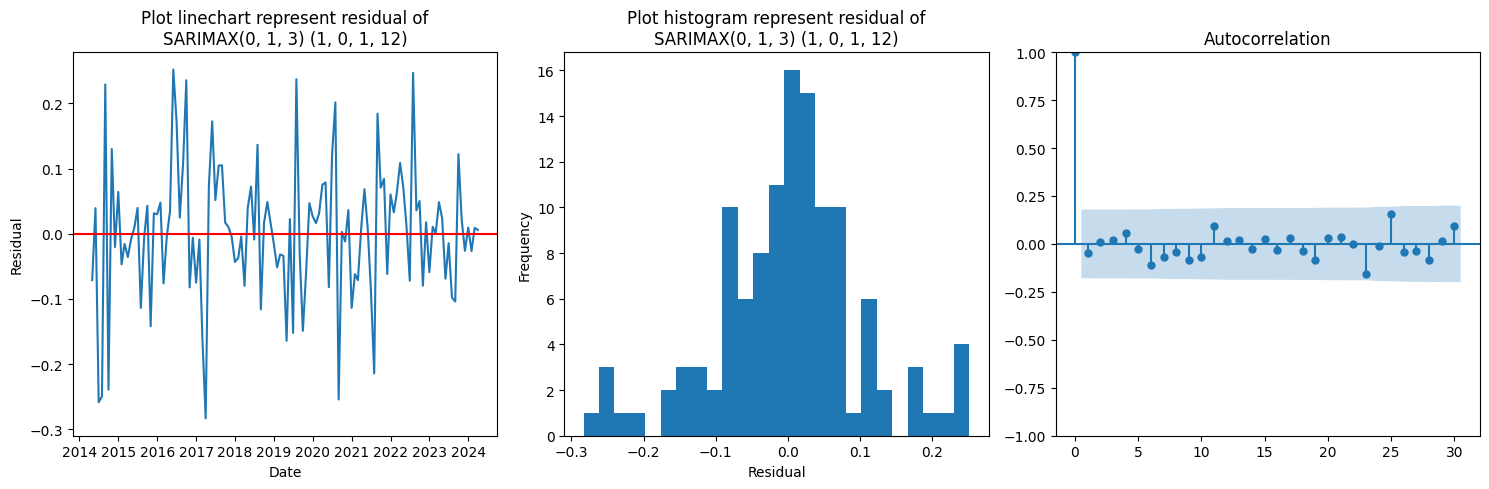

In [41]:
sarimax_grid = SARIMAX(endog = y_tf, exog = x_train[["x4"]], order = (0, 1, 3), seasonal_order = (1, 0, 1, 12), concentrate_scale = True).fit()
print(sarimax_grid.summary())

#Error
#print()
#print("MAPE Train: ", MAPE(y_train[12:], sarimax_grid.fittedvalues[12:]) * 100)
#print("MAPE Test: ", MAPE(y_test, sarimax_grid.forecast(steps = len(y_test))) * 100)

# diagnostic
resid_sarimax = sarimax_grid.resid[12:]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5), facecolor = "w")
ax[0].plot(resid_sarimax.to_timestamp())
ax[0].axhline(y = 0, color = "r")
ax[0].set(xlabel = "Date", ylabel = "Residual", title = "Plot linechart represent residual of\nSARIMAX(0, 1, 3) (1, 0, 1, 12)")
ax[1].hist(resid_sarimax, bins = 25)
ax[1].set(xlabel = "Residual", ylabel = "Frequency",title = "Plot histogram represent residual of\nSARIMAX(0, 1, 3) (1, 0, 1, 12)")
plot_acf(resid_sarimax, lags = int(len(resid_sarimax) / 4), ax = ax[2])
plt.tight_layout()
plt.show()

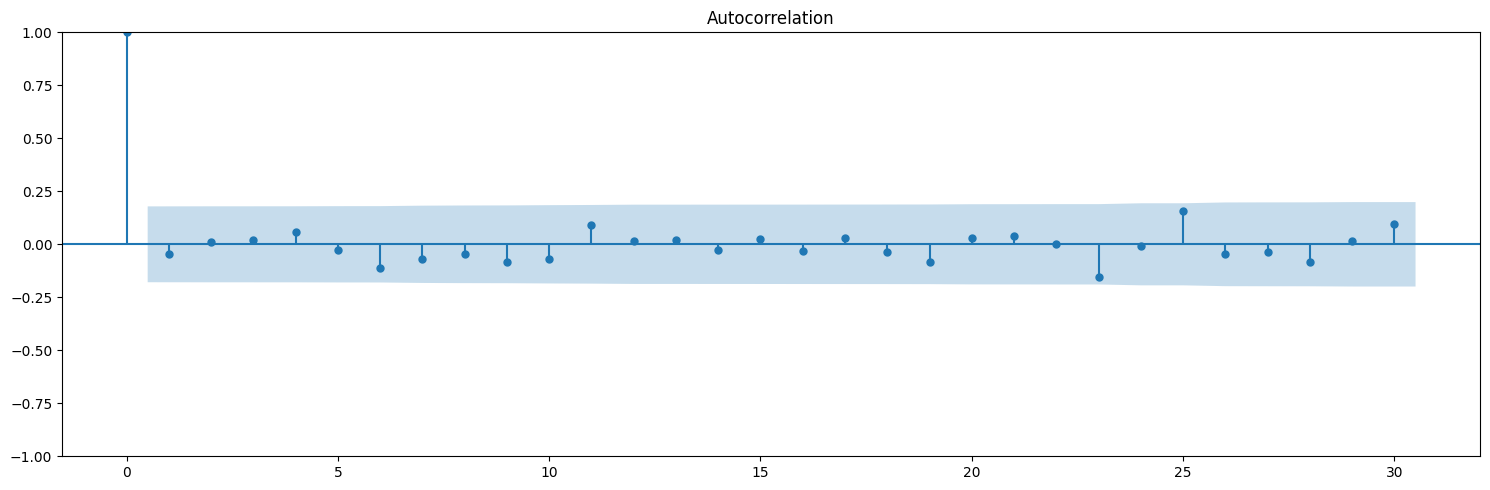

In [42]:
fig, ax = plt.subplots(figsize = (15, 5), facecolor = "w")
plot_acf(sarimax_grid.resid[12:], lags = int(len(sarimax_grid.resid[12:]) / 4), ax = ax)
plt.tight_layout()
plt.show()

In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lag_idx = round(len(sarimax_grid.resid[12:])/4, 0)
bj = acorr_ljungbox(sarimax_grid.resid[12:], lags = lag_idx, return_df = True)
bj.tail().T

,26,27,28,29,30
lb_stat,15.832716,16.040053,17.142931,17.173581,18.657546
lb_pvalue,0.940144,0.952180,0.945712,0.959416,0.946889


# Forecast dataframe

In [84]:
sarimax_model1 = power_y.inverse_transform(sarimax_model.forecast(steps=len(y_train), exog=x_train[['x4']]).values.reshape(-1, 1))
sarimax_model2 = pd.Series(sarimax_model1.flatten(), index=y_train.index)
sarimax_model2

,0
2013-05,158.250439
2013-06,164.027400
2013-07,154.674193
2013-08,152.166939
2013-09,192.912611
...,...
2023-12,135.729570
2024-01,132.391959
2024-02,120.591596
2024-03,103.910443


In [73]:
sarimax_grid1 = power_y.inverse_transform(sarimax_grid.forecast(steps=len(y_train), exog=x_train[['x4']]).values.reshape(-1, 1))
sarimax_grid2 = pd.Series(sarimax_grid1.flatten(), index=y_train.index)
sarimax_grid2

,0
2013-05,130.329184
2013-06,138.110833
2013-07,136.747487
2013-08,140.213007
2013-09,175.995951
...,...
2023-12,486.395404
2024-01,479.597698
2024-02,447.896776
2024-03,399.647422


In [85]:
fitted = pd.DataFrame(
    {
        "y_train": y_train[12:],
        "SARIMAX": sarimax_model2[12:],
        "SARIMAX Grid": sarimax_grid2[12:]
    }
)
fitted

,y_train,SARIMAX,SARIMAX Grid
2014-05,73.07,105.619213,140.605519
2014-06,70.86,110.369794,149.383275
2014-07,53.69,106.100567,148.412531
2014-08,36.80,106.029300,152.043955
2014-09,45.64,137.188416,191.054022
...,...,...,...
2023-12,208.10,135.729570,486.395404
2024-01,209.52,132.391959,479.597698
2024-02,191.17,120.591596,447.896776
2024-03,168.70,103.910443,399.647422


In [75]:
fitted.to_excel(r"fitted train.xlsx")

In [86]:
error_fit = pd.DataFrame()
for i in fitted.columns[1:]:
    error_fit[i] = fitted["y_train"] - fitted[i]
error_fit

,SARIMAX,SARIMAX Grid
2014-05,-32.549213,-67.535519
2014-06,-39.509794,-78.523275
2014-07,-52.410567,-94.722531
2014-08,-69.229300,-115.243955
2014-09,-91.548416,-145.414022
...,...,...
2023-12,72.370430,-278.295404
2024-01,77.128041,-270.077698
2024-02,70.578404,-256.726776
2024-03,64.789557,-230.947422


In [77]:
error_fit.to_excel(r"Seasonal resid.xlsx")

In [87]:
import plotly.graph_objects as go

fig = go.Figure()
for i in list(fitted.columns):
    fig.add_trace(go.Scatter(x = fitted.index.to_timestamp(), y = fitted[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for compare train model",
                  xaxis_title = "Date",
                  yaxis_title = "Exchange",
                  legend_title = "Model")
fig.show()

In [88]:
from sklearn.metrics import r2_score

diag_fitted = pd.DataFrame()
diag_fitted.index = fitted.columns[1:]
diag_fitted['MAPE'] = [MAPE(fitted['y_train'], fitted[i]) * 100 for i in fitted.columns[1:]]
# diag_fitted['RMSE'] = [sqrt(MSE(fitted['y_train'], fitted[i])) for i in fitted.columns[1:]]
# diag_fitted['MAE']  = [MAE(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]
diag_fitted['Rsquared'] = [r2_score(fitted['y_train'], fitted[i]) for i in fitted.columns[1:]]  # เพิ่มบรรทัดนี้

round(diag_fitted, 4)

,MAPE,Rsquared
SARIMAX,79.8764,-0.1462
SARIMAX Grid,276.9264,-11.9428


# Forecast dataframe

In [93]:
sarimax_t_model1 = power_y.inverse_transform(sarimax_model.forecast(steps=len(y_test), exog=x_test[['x4']]).values.reshape(-1, 1))
sarimax_t_model2 = pd.Series(sarimax_t_model1.flatten(), index=y_test.index)
sarimax_t_model2

,0
2024-05,158.268031
2024-06,163.677487
2024-07,156.270546
2024-08,152.841195
2024-09,191.386681
2024-10,217.058919
2024-11,224.230592
2024-12,228.466465
2025-01,215.625937
2025-02,189.642288


In [95]:
sarimax_t_grid1 = power_y.inverse_transform(sarimax_grid.forecast(steps=len(y_test), exog=x_test[['x4']]).values.reshape(-1, 1))
sarimax_t_grid2 = pd.Series(sarimax_t_grid1.flatten(), index=y_test.index)
sarimax_t_grid2

,0
2024-05,130.337607
2024-06,137.939397
2024-07,137.567246
2024-08,140.574586
2024-09,175.183771
2024-10,200.919361
2024-11,214.178839
2024-12,225.028754
2025-01,221.970201
2025-02,206.780248


In [96]:
forecast = pd.DataFrame(
    {
        "y_test":        y_test,
        "SARIMAX":       sarimax_t_model2,
        "SARIMAX Grid":  sarimax_t_grid2
    }
)
forecast

,y_test,SARIMAX,SARIMAX Grid
2024-05,122.28,158.268031,130.337607
2024-06,123.80,163.677487,137.939397
2024-07,114.57,156.270546,137.567246
2024-08,119.58,152.841195,140.574586
2024-09,153.57,191.386681,175.183771
2024-10,204.64,217.058919,200.919361
2024-11,213.81,224.230592,214.178839
2024-12,219.47,228.466465,225.028754
2025-01,202.04,215.625937,221.970201
2025-02,181.58,189.642288,206.780248


In [97]:
forecast.to_excel(r"forecast test.xlsx")

In [99]:
import plotly.graph_objects as go

fig = go.Figure()
for i in list(forecast.columns):
    fig.add_trace(go.Scatter(x = forecast.index.to_timestamp(), y = forecast[i], name = i, line_shape='linear'))

fig.update_layout(title = "Line chart for compare train model",
                  xaxis_title = "Date",
                  yaxis_title = "y",
                  legend_title = "Model")
fig.show()

In [100]:
from sklearn.metrics import r2_score

diag_forecast = pd.DataFrame()
diag_forecast.index = forecast.columns[1:]
diag_forecast['MAPE'] = [MAPE(forecast['y_test'], forecast[i]) * 100 for i in forecast.columns[1:]]
# diag_forecast['RMSE'] = [sqrt(MSE(forecast['y_test'], forecast[i])) for i in forecast.columns[1:]]
# diag_forecast['MAE']  = [MAE(forecast['y_test'], forecast[i]) for i in forecast.columns[1:]]
diag_forecast['Rsquared'] = [r2_score(forecast['y_test'], forecast[i]) for i in forecast.columns[1:]]  # เพิ่มบรรทัดนี้

round(diag_forecast, 4)

,MAPE,Rsquared
SARIMAX,15.5099,0.5504
SARIMAX Grid,10.6428,0.7854
